# Comparison of Computing `logdet` with Various Methods (Practical Matirx)



### Objective

Compares $\mathrm{log} \mathrm{det}\mathbf{A}$ using three algorithms:

* **SLQ**: stochastic numerical solution, all 32-bit, 64-bit, and 128-bit data type.
* **Cholesky**: direct numerical solution, only 64-bit data type.

Matrix $\mathbf{A}$ are sparse matrices from real applications.

This notebook will plot

* Process time of each method.
* Accuracy of computing traceinv.

### Matrices

Matrix $\mathbf{A}$ are symmetric positive-definite matrices from real applications obtained from [sparsesuite matrix collection](https://sparse.tamu.edu/).

* ['nos5'](https://sparse.tamu.edu/HB/nos5)
* ['mhd4800b'](https://sparse.tamu.edu/Bai/mhd4800b)
* ['bodyy6'](https://sparse.tamu.edu/Pothen/bodyy6)
* ['G2_circuit'](https://sparse.tamu.edu/AMD/G2_circuit)
* ['parabolic_fem'](https://sparse.tamu.edu/Wissgott/parabolic_fem)
* ['StocF-1465'](https://sparse.tamu.edu/Janna/StocF-1465)
* ['Bump_2911'](https://sparse.tamu.edu/Janna/Bump_2911)
* ['Queen_4147'](https://sparse.tamu.edu/Janna/Queen_4147): This matrix is so large that 32-bit integers cannot hold the indices of this matrix. Rather, 32-bit `unsigned int` should be used.


### Consideratons

**parameters:**
* In SLQ and Hutchinson methods, `min_num_samples` and `max_num_samples` are fixed to 200.
* In SLQ method, `lanczos_degree` is 80. Lanczos degree of 50 is no enough.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.

###Notes:

* In Cholsky method, the computation cannot be continued till the 7th and 8th matrix (`Bump_2911`, `Queen_4147`), becase of memory error. I limited the computation of logdet with Chokesky to the matrices of size 2e+6.


### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/compare_methods_practical_matrix.py` by

    cd /benchmark/scripts
    python ./compare_methods_practical_matrix.py -a -f logdet
    
where `-a` will generate all 32-bit, 64-bit, and 128-bit results. Also, `-f` determines which function to compute. The script can compute both traceinv and logdet.
        
The output is stored in `/benchnmark/pickle_results/compare_methods_practical_matrix_logdet.pickle`.

#### 2. Run on cluster

To run this script on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_compare_methods_practical_matrix_logdet.sh
   
When submitting the jobs, make sure that the cpu is the same as the previous runs. For isnatnce, nodes on savio2 cluster between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

To run this script on a cluster with TORQUE:

    cd jobfiles
    qsub jobfile_compare_methods_practical_matrix_logdet.pbs

In [1]:
import numpy
import numpy.polynomial.polynomial as poly
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

# Plot savefig settings
extension = 'pdf' # 'png'
transparent=True
dpi = 500

#matplotlib.rcParams['text.antialiased'] = True
#matplotlib.rcParams['lines.antialiased'] = True
#matplotlib.rcParams['patch.antialiased'] = True

In [2]:
benchmark_dir = '..'
filename = 'compare_methods_practical_matrix_logdet.pickle'
results_filename = join(benchmark_dir, 'pickle_results', filename)


with open(results_filename, 'rb') as file_:
    benchmark_results = pickle.load(file_)
    
print('Config:')
pp.pprint(benchmark_results['config'])
print('')
print('Devices:')
pp.pprint(benchmark_results['devices'])

print('')
data_results = benchmark_results['data_results']
print('num data: %d' % len(data_results))

nnz = numpy.zeros((len(data_results), ))
size = numpy.zeros((len(data_results), ))
names = []
for i in range(len(data_results)):
    nnz[i] = data_results[i]['type_results'][0]['result']['info_s']['matrix']['nnz']
    size[i] = data_results[i]['type_results'][0]['result']['info_s']['matrix']['size']
    name = data_results[i]['data_name']
    names.append(name.encode('unicode_escape').decode())

print('')
print('data names:')
print(names)

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'gram': False,
    'lanczos_degree': 80,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'verbose': False}

Devices:
{   'cpu_name': 'Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz',
    'num_all_cpu_threads': 40}

num data: 8

data names:
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_4147']


In [3]:
# Check if cholmod used for the Cholesky method
data_results[0]['type_results'][1]['result']['info_c']['solver']

{'version': '0.8.3', 'method': 'cholesky', 'cholmod_used': True}


i: 0, index: 0, name: nos5, nnz: 5172, size: 468
i: 1, index: 1, name: mhd4800b, nnz: 27520, size: 4800
i: 2, index: 2, name: bodyy6, nnz: 134208, size: 19366
i: 3, index: 3, name: G2_circuit, nnz: 726674, size: 150102
i: 4, index: 4, name: parabolic_fem, nnz: 3674625, size: 525825
i: 5, index: 5, name: StocF-1465, nnz: 21005389, size: 1465137
i: 6, index: 6, name: Bump_2911, nnz: 127729899, size: 2911419
i: 7, index: 7, name: Queen_4147, nnz: 316548962, size: 4147110


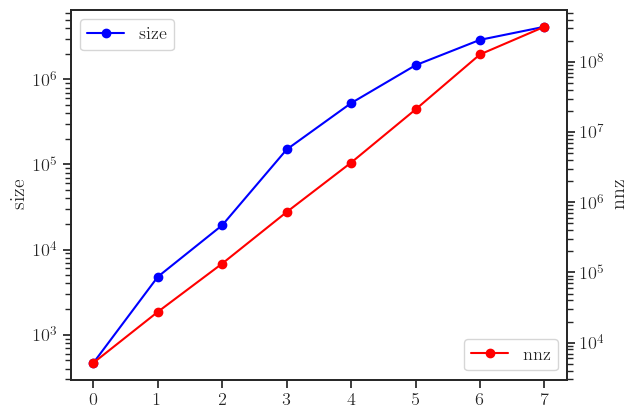

In [4]:
# Sorting data by nnz, plot nnz and matrix size
sort_index = numpy.argsort(nnz)

fig, ax = plt.subplots()
x = numpy.arange(len(data_results))
ax.plot(size[sort_index], '-o', color='blue', label='size')
ax.set_ylabel('size')
ax.set_xticks(x)
#ax.set_xticklabels(names)
ax2 = ax.twinx()
ax2.plot(nnz[sort_index], '-o', color='red', label='nnz')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
ax2.set_ylabel('nnz')
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)

print('')
for i in range(len(data_results)):
    print('i: %d, index: %d, name: %s, nnz: %d, size: %d' 
          % (i, sort_index[i], names[sort_index[i]], nnz[i], size[i]))

In [5]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]

def log_line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_xi = numpy.log2(xi)
    log2_y = numpy.log2(y)
    
    coefs = poly.polyfit(log2_x, log2_y, 1)
    log2_yi = poly.polyval(log2_xi, coefs)
    
    return 2**log2_yi

slope_s: 0.990306
slope_s: 0.975999
slope_c: 1.216101
slope_s: 1.005748
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_4147']
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465', 'Bump_2911', 'Queen_4147']
[     5172     27520    134208    726674   3674625  21005389 127729899
 316548962]
Plot saved to "compare_methods_practical_matrix_logdet_time.pdf".


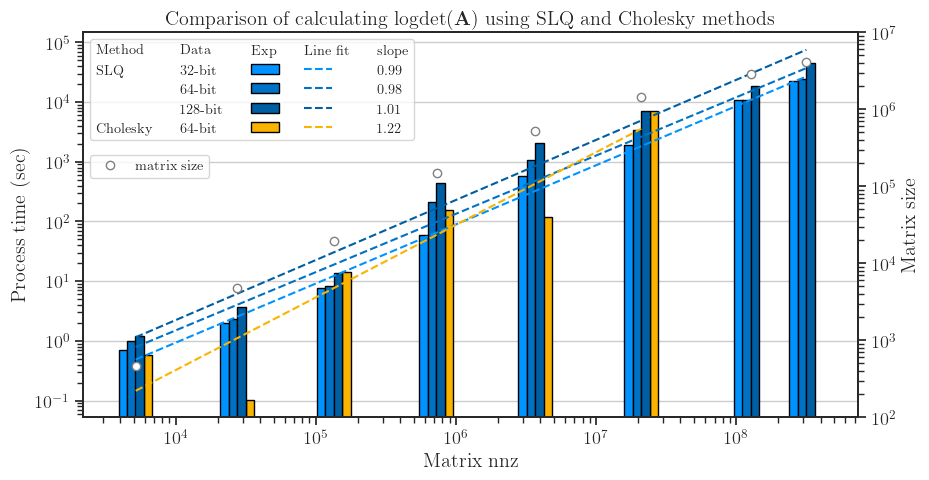

In [6]:
## Plotting Elapsed time vs Matrix Size

# Settings
chol_indices = numpy.arange(0, 6)  # set the range of datasets to be used for cholesky plots
plot_line_fit = True
plot_cpu_proc_time = True                             # True plots cpu_proc_time, False plots alg_wall_time
slq_color = ['#0093FF', '#0072C6', '#005EA3']         # corresponding to 32-bit, 64-bit, and 128-bit
#chol_color = ['#FAB300', '#C77E00']               # corresponding to 32-bit, 64-bit
chol_color = ['#FAB300', '#FAB300']               # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                          # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
data_results_ = data_results.copy()

#remove_indices = [0, 1, 2]
remove_indices = []

for index in remove_indices[::-1]:
    del data_results_[index]

# Initialize arrays
num_data = len(data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
matrix_name = []
matrix_nnz = numpy.zeros((num_data, ), dtype=int)
matrix_density = numpy.zeros((num_data, ), dtype=float)
data_type = numpy.zeros((num_data, num_types), dtype=int)
slq_trace = numpy.zeros((num_data, num_types), dtype=float)
slq_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
slq_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
slq_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)
chol_trace = numpy.zeros((num_data, num_types), dtype=float)
chol_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
chol_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
chol_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)

for data_index in range(num_data):

    data_result = data_results_[data_index]
    matrix_name.append(data_result['data_name'])
    type_results = data_result['type_results']

    matrix_size[data_index] = type_results[0]['result']['info_s']['matrix']['size']
    matrix_nnz[data_index] = type_results[0]['result']['info_s']['matrix']['nnz']
    matrix_density[data_index] = type_results[0]['result']['info_s']['matrix']['density']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(type_results)):

        type_result = type_results[type_index]
        data_type[data_index, type_index] = type_result['data_type']
        result = type_result['result']

        slq_trace[data_index, type_index] = numpy.mean(result['trace_s'])
        slq_tot_wall_time[data_index, type_index] = numpy.mean(result['info_s']['time']['tot_wall_time'])
        slq_alg_wall_time[data_index, type_index] = numpy.mean(result['info_s']['time']['alg_wall_time'])
        slq_cpu_proc_time[data_index, type_index] = numpy.mean(result['info_s']['time']['cpu_proc_time'])
          
        if not numpy.isnan(result['trace_c']):
            chol_trace[data_index, type_index] = numpy.mean(result['trace_c'])
        if result['info_c'] != {}:
            chol_tot_wall_time[data_index, type_index] = numpy.mean(result['info_c']['time']['tot_wall_time'])
            chol_alg_wall_time[data_index, type_index] = numpy.mean(result['info_c']['time']['alg_wall_time'])
            chol_cpu_proc_time[data_index, type_index] = numpy.mean(result['info_c']['time']['cpu_proc_time'])
            
        #if not numpy.isnan(result['trace_c2']):
        #    chol_trace[data_index, type_index] = numpy.mean(result['trace_c2'])
        #if result['info_c2'] != {}:
        #    chol_tot_wall_time[data_index, type_index] = numpy.mean(result['info_c2']['time']['tot_wall_time'])
        #    chol_alg_wall_time[data_index, type_index] = numpy.mean(result['info_c2']['time']['alg_wall_time'])
        #    chol_cpu_proc_time[data_index, type_index] = numpy.mean(result['info_c2']['time']['cpu_proc_time'])

slope_s = numpy.zeros((num_types, ), dtype=float)
slope_c = numpy.zeros((num_types, ), dtype=float)
slq_matrix_nnz_i = numpy.logspace(numpy.log2(matrix_nnz[0]), numpy.log2(matrix_nnz[-1]), 100, base=2)
chol_matrix_nnz_i = numpy.logspace(numpy.log2(matrix_nnz[chol_indices[0]]),
                                   numpy.log2(matrix_nnz[chol_indices[-1]]), 100, base=2)
slq_alg_wall_time_i = [None] * len(type_results)
slq_cpu_proc_time_i = [None] * len(type_results)
chol_alg_wall_time_i = [None] * len(type_results)
chol_cpu_proc_time_i = [None] * len(type_results)

for type_index in range(len(type_results)):
    
    type_ = data_type[0][type_index]

    if plot_cpu_proc_time:
        slope_s[type_index] = find_slope(matrix_nnz, slq_cpu_proc_time[:, type_index])
    else:
        slope_s[type_index] = find_slope(matrix_nnz, slq_alg_wall_time[:, type_index])
    print('slope_s: %f' % slope_s[type_index])
    
    # Interpolation
    slq_cpu_proc_time_i[type_index] = log_line_fit(slq_matrix_nnz_i, matrix_nnz,
                                                   slq_cpu_proc_time[:, type_index]) 
    slq_alg_wall_time_i[type_index] = log_line_fit(slq_matrix_nnz_i, matrix_nnz,
                                                   slq_alg_wall_time[:, type_index])
    
    if type_ == 64:
        if plot_cpu_proc_time:
            slope_c[type_index] = find_slope(matrix_nnz[chol_indices],
                                             chol_cpu_proc_time[chol_indices, type_index])
        else:
            slope_c[type_index] = find_slope(matrix_nnz[chol_indices],
                                             chol_alg_wall_time[chol_indices, type_index])
        print('slope_c: %f' % slope_c[type_index])
    
        # Interpolation
        chol_cpu_proc_time_i[type_index] = log_line_fit(chol_matrix_nnz_i, matrix_nnz[chol_indices],
                                                   chol_cpu_proc_time[chol_indices, type_index])
        chol_alg_wall_time_i[type_index] = log_line_fit(chol_matrix_nnz_i, matrix_nnz[chol_indices],
                                                   chol_alg_wall_time[chol_indices, type_index])

# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
#abscissa = matrix_size  
abscissa = matrix_nnz

# Set what should be on the y axis of the twin plot.
#ordinate = matrix_density
ordinate = matrix_size
#ordinate = matrix_nnz
        
sorting_index = numpy.argsort(abscissa)
abscissa = abscissa[sorting_index]
ordinate = ordinate[sorting_index]
slq_alg_wall_time = slq_alg_wall_time[sorting_index, :]
slq_cpu_proc_time = slq_cpu_proc_time[sorting_index, :]
chol_alg_wall_time = chol_alg_wall_time[sorting_index, :]
chol_cpu_proc_time = chol_cpu_proc_time[sorting_index, :]

print(matrix_name)
matrix_name_ = []
for i in sorting_index:
    matrix_name_.append(matrix_name[i])
matrix_name = matrix_name_

print(matrix_name)
print(abscissa)
            
# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

#width = 0.17
width = 0.14
logsp = numpy.logspace(-width/1.55, width/1.55, 4)
slq_widths = logsp[:3]
chol_widths = logsp[3]

for type_index in range(num_types):
    
    type_ = data_type[0][type_index]
    x = slq_widths[type_index]*abscissa
    if plot_cpu_proc_time:
        ax.bar(x, slq_cpu_proc_time[:, type_index],
               width=width*x, edgecolor='black',
               color=slq_color[type_index], label='SLQ ' + str(type_) + '-bit')
    else:
        ax.bar(x, slq_alg_wall_time[:, type_index],
               width=width*x, edgecolor='black',
               color=slq_color[type_index], label='SLQ ' + str(type_) + '-bit')
    
    if plot_line_fit:
        if plot_cpu_proc_time:
            ax.plot(slq_matrix_nnz_i, slq_cpu_proc_time_i[type_index], '--', color=slq_color[type_index],
                    label='linear fit, slope: %0.2f' % slope_s[type_index])
        else:
            ax.plot(slq_matrix_nnz_i, slq_alg_wall_time_i[type_index], '--', color=slq_color[type_index],
                    label='linear fit, slope: %0.2f' % slope_s[type_index])
    
    if type_ == 64:
        x = chol_widths*abscissa
        if plot_cpu_proc_time:
            ax.bar(x, chol_cpu_proc_time[:, type_index],
                   width=width*x, edgecolor='black',
               color=chol_color[type_index], label='Cholesky ' + str(type_) + '-bit')
        else:
            ax.bar(x, chol_alg_wall_time[:, type_index],
                   width=width*x, edgecolor='black',
               color=chol_color[type_index], label='Cholesky ' + str(type_) + '-bit')
        
        if plot_line_fit:
            if plot_cpu_proc_time:
                ax.plot(chol_matrix_nnz_i, chol_cpu_proc_time_i[type_index], '--', color=chol_color[type_index],
                    label='linear fit, slope: %0.2f' % slope_s[type_index])
            else:
                ax.plot(chol_matrix_nnz_i, chol_alg_wall_time_i[type_index], '--', color=chol_color[type_index],
                    label='linear fit, slope: %0.2f' % slope_s[type_index])
        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()

if plot_line_fit:
    handles = [extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra,
               extra, handles[4], handles[5], handles[7], handles[6],
               extra, handles[0], handles[1], handles[3], handles[2],
               extra, extra, extra, extra, extra]
    labels = ["Method", "SLQ", "", "", "Cholesky",
              "Data", "32-bit", "64-bit", "128-bit", "64-bit",
              "Exp", "", "", "", "",
              "Line fit", "", "", "", "",
              "slope", "%0.2f" % slope_s[0], "%0.2f" % slope_s[1], "%0.2f" % slope_s[2], "%0.2f" % slope_c[1]]
else:
    handles = [extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra,
               extra, handles[0], handles[1], handles[3], handles[2]]
    labels = ["Method", "SLQ", "", "", "Cholesky",
              "Data", "32-bit", "64-bit", "128-bit", "64-bit",
              "Experiment", "", "", "", ""]

ax2 = ax.twinx()
ax2.plot(abscissa, ordinate, 'o', color='gray', markerfacecolor='white', label='matrix size')
#ax.legend(handles, labels, bbox_to_anchor=(1.1, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='small')
if plot_line_fit:
    ncol = 5
else:
    ncol = 3
ax.legend(handles, labels, loc='upper left', ncol=ncol, handletextpad = -2, fontsize='x-small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
#ax2.legend(bbox_to_anchor=(1.15, 0.7), loc='upper left', ncol=1, fontsize='small')
ax2.legend(bbox_to_anchor=(0, 0.7), loc='upper left', ncol=1, fontsize='x-small')
    
plt.xscale('log', base=10)
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.set_ylim([1e2, 1e7])
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(cpu_blas_num_cpu_devices)

if plot_cpu_proc_time:
    ax.set_ylabel('Process time (sec)')
else:
    ax.set_ylabel('Elapsed time (sec)')
ax2.set_ylabel('Matrix size')
ax.set_title('Comparison of calculating $\mathrm{logdet}(\mathbf{A})$ using SLQ and Cholesky methods')
#ax.set_xlabel('Matrix size')
ax.set_xlabel('Matrix nnz')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'compare_methods_practical_matrix_logdet_time' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465']
['nos5', 'mhd4800b', 'bodyy6', 'G2_circuit', 'parabolic_fem', 'StocF-1465']
[    5172    27520   134208   726674  3674625 21005389]
Plot saved to "compare_methods_practical_matrix_logdet_accuracy.pdf".


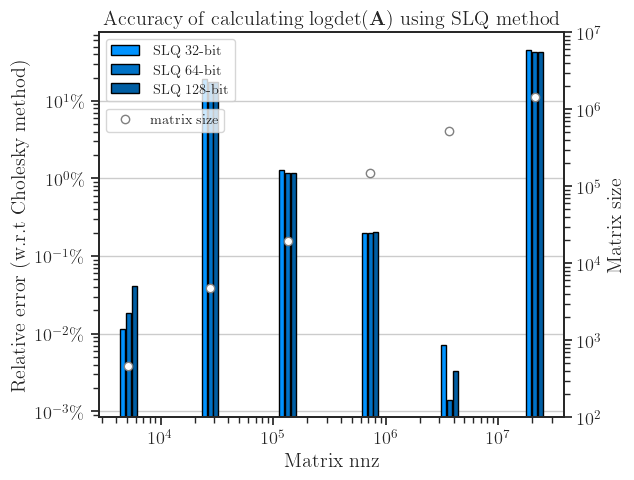

In [7]:
## Plotting Elapsed time vs Matrix Size
# Note: The errors are computed by comparing with 128-bit with no CBLAS.

# Settings
plot_log = True
slq_color = ['#0093FF', '#0072C6', '#005EA3']    # corresponding to 32-bit, 64-bit, and 128-bit
chol_color = ['#FAB300', '#C77E00']          # corresponding to 32-bit, 64-bit
markers = ['-o', '-s', '-D']                       # corresponding to 32-bit, 64-bit, and 128-bit

# Remove some data
data_results_ = data_results.copy()

remove_indices = [6, 7]
#remove_indices = []

for index in remove_indices[::-1]:
    del data_results_[index]
    
# Initialize arrays
num_data = len(data_results_)
num_types = 3   # correspondng to 32-bit, 64-bit, and 128-bit
matrix_size = numpy.zeros((num_data, ), dtype=int)
matrix_name = []
matrix_nnz = numpy.zeros((num_data, ), dtype=int)
matrix_density = numpy.zeros((num_data, ), dtype=float)
data_type = numpy.zeros((num_data, num_types), dtype=int)
slq_trace = numpy.zeros((num_data, num_types), dtype=float)
slq_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
slq_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
slq_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)
chol_trace = numpy.zeros((num_data, num_types), dtype=float)
chol_tot_wall_time = numpy.zeros((num_data, num_types), dtype=float)
chol_alg_wall_time = numpy.zeros((num_data, num_types), dtype=float)
chol_cpu_proc_time = numpy.zeros((num_data, num_types), dtype=float)

slq_trace[:, :] = numpy.nan
chol_trace[:, :] = numpy.nan

for data_index in range(num_data):

    data_result = data_results_[data_index]
    matrix_name.append(data_result['data_name'])
    type_results = data_result['type_results']

    matrix_size[data_index] = type_results[0]['result']['info_s']['matrix']['size']
    matrix_nnz[data_index] = type_results[0]['result']['info_s']['matrix']['nnz']
    matrix_density[data_index] = type_results[0]['result']['info_s']['matrix']['density']

    # Iterate over 32-bit, 64-bit and 128-bit data
    for type_index in range(len(type_results)):

        type_result = type_results[type_index]
        data_type[data_index, type_index] = type_result['data_type']
        result = type_result['result']

        slq_trace[data_index, type_index] = numpy.mean(result['trace_s'])
        slq_tot_wall_time[data_index, type_index] = numpy.mean(result['info_s']['time']['tot_wall_time'])
        slq_alg_wall_time[data_index, type_index] = numpy.mean(result['info_s']['time']['alg_wall_time'])
        slq_cpu_proc_time[data_index, type_index] = numpy.mean(result['info_s']['time']['cpu_proc_time'])
          
        if not numpy.isnan(result['trace_c']):
            chol_trace[data_index, type_index] = numpy.mean(result['trace_c'])
            
# Relative error of SLQ trace with respect to Cholesky method
slq_trace_relative_error = numpy.zeros((num_data, num_types), dtype=float)
slq_trace_relative_error[:, :] = numpy.nan
percent = 100.0
type_index_64_bit = 1
for data_index in range(num_data):
    for type_index in range(len(type_results)):
        if not numpy.isnan(chol_trace[data_index, type_index_64_bit]):
            slq_trace_relative_error[data_index, type_index] = percent * \
                numpy.abs((slq_trace[data_index, type_index] - chol_trace[data_index, type_index_64_bit]) / \
                          chol_trace[data_index, type_index_64_bit])
    
# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
#abscissa = matrix_size  
abscissa = matrix_nnz

# Set what should be on the y axis of the twin plot.
#ordinate = matrix_density
ordinate = matrix_size
#ordinate = matrix_nnz
        
sorting_index = numpy.argsort(abscissa)
abscissa = abscissa[sorting_index]
ordinate = ordinate[sorting_index]
slq_alg_wall_time = slq_alg_wall_time[sorting_index, :]
slq_cpu_proc_time = slq_cpu_proc_time[sorting_index, :]
chol_alg_wall_time = chol_alg_wall_time[sorting_index, :]
chol_cpu_proc_time = chol_cpu_proc_time[sorting_index, :]
slq_trace_relative_error = slq_trace_relative_error[sorting_index, :]

print(matrix_name)
matrix_name_ = []
for i in sorting_index:
    matrix_name_.append(matrix_name[i])
matrix_name = matrix_name_

print(matrix_name)
print(abscissa)
            
# Plotting
fig, ax = plt.subplots(figsize=(6, 5))

#width = 0.17
width = 0.1
slq_widths = numpy.logspace(-width/1.93, width/1.93, 3)

for type_index in range(num_types):
    
    type_ = data_type[0][type_index]
    x = slq_widths[type_index]*abscissa
    ax.bar(x, slq_trace_relative_error[:, type_index],
           width=width*x, edgecolor='black',
       color=slq_color[type_index], label='SLQ ' + str(type_) + '-bit')
        
# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
#handles = [extra, extra, extra, extra,
#           extra, handles[0], handles[2], handles[4], 
#           extra, handles[1], handles[3], extra]
#labels = ["", "32 bit", "64 bit", "128 bit",
#          "no BLAS", "", "", "",
#          "BLAS", "", "", ""]


ax2 = ax.twinx()
ax2.plot(abscissa, ordinate, 'o', color='gray', markerfacecolor='white', label='matrix size')
#ax.legend(handles, labels, bbox_to_anchor=(1.1, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='small')
ax.legend(handles, labels, loc='upper left', ncol=1, handletextpad = 1, fontsize='x-small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
#ax2.legend(bbox_to_anchor=(1.15, 0.7), loc='upper left', ncol=1, fontsize='small')
ax2.legend(bbox_to_anchor=(0, 0.82), loc='upper left', ncol=1, fontsize='x-small')
    
plt.xscale('log', base=10)
ax.set_yscale('log', base=10)
ax2.set_yscale('log', base=10)
ax2.set_ylim([1e2, 1e7])
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(cpu_blas_num_cpu_devices)

ax.set_ylabel('Relative error (w.r.t Cholesky method)')
ax2.set_ylabel('Matrix size')
ax.set_title('Accuracy of calculating $\mathrm{logdet}(\mathbf{A})$ using SLQ method')
#ax.set_xlabel('Matrix size')
ax.set_xlabel('Matrix nnz')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'compare_methods_practical_matrix_logdet_accuracy' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))